<a href="https://colab.research.google.com/github/jameswilliam38/Time-Series-Forecasting/blob/main/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting with Prophet

#Import Library

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go
from datetime import datetime, timedelta
from prophet.diagnostics import cross_validation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


## Read dataset dan convert data harian menjadi bulanan

In [ ]:
#Read data, ganti kolom jadi Date dan precipitation, kolom Date jadi Datetime
jakBar = pd.read_csv("/content/gdrive/MyDrive/ProjekJakarta/CurahHujanJakbar2014-2024.csv")
jakBar.columns = ['Date', 'Precipitation']
jakBar['Date'] = pd.to_datetime(jakBar['Date'])
print(jakBar)

           Date  Precipitation
0    2014-01-01         11.661
1    2014-01-02          1.661
2    2014-01-03          3.887
3    2014-01-04         11.661
4    2014-01-05         11.661
...         ...            ...
3757 2024-04-15          3.847
3758 2024-04-16          0.000
3759 2024-04-17         12.339
3760 2024-04-18         12.339
3761 2024-04-19          0.020

[3762 rows x 2 columns]


In [ ]:
#Ubah data harian jadi data bulanan (SUM SEMUANYA)

#Date jadi index dlu
jakBar.set_index('Date', inplace=True)

#Resample data jadi monthly series dan sum per bulannya
jakbar_bulanan = jakBar.resample('M').sum()

#balikin index, date jadi fitur lgi
jakbar_bulanan.reset_index(inplace=True)

# Step 6: Save the result to a new CSV file
jakbar_bulanan.to_csv('Precipitation_Bulanan_Jakbar.csv', index=False)

In [ ]:
#Read dataset baru (bulanan)
jakbar = pd.read_csv("/content/Precipitation_Bulanan_Jakbar.csv")

In [ ]:
#Kolom date jadi datetime
jakbar['Date'] = pd.to_datetime(jakbar['Date'])

          Date  Precipitation
0   2014-01-31        754.203
1   2014-02-28        514.129
2   2014-03-31        247.035
3   2014-04-30        197.551
4   2014-05-31        120.596
..         ...            ...
119 2023-12-31         49.395
120 2024-01-31        337.704
121 2024-02-29        267.375
122 2024-03-31        248.121
123 2024-04-30        130.738

[124 rows x 2 columns]


<Axes: xlabel='Date'>

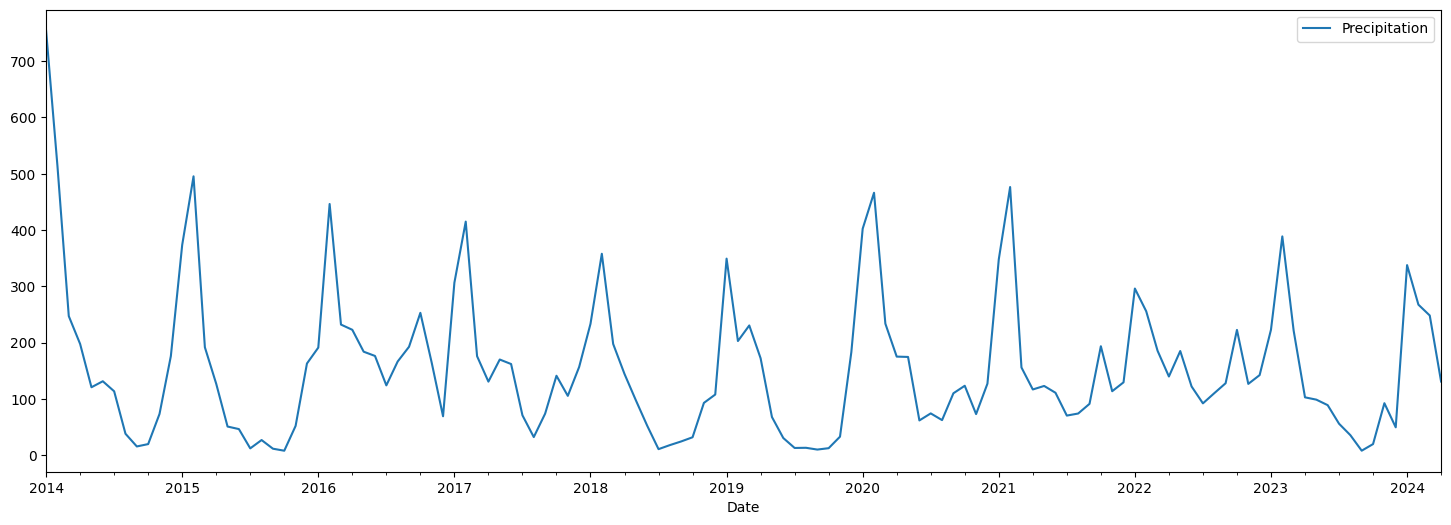

In [ ]:
#Data bulanan
print(jakbar)
jakbar.plot(x='Date', y='Precipitation', figsize=(18,6))

### Boxplot dari data, dapat melihat outliernya

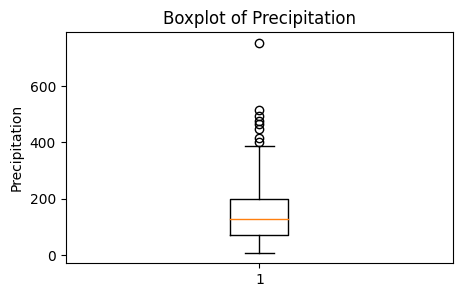

In [ ]:
#boxplot data
plt.figure(figsize=(5, 3))
plt.boxplot(jakbar['Precipitation'], showfliers=True)
plt.title('Boxplot of Precipitation')
plt.ylabel('Precipitation')
plt.show()

# Preproses

## Removing outlier menggunakan IQR

In [ ]:
# Removing outlier pake IQR
Q1 = jakbar['Precipitation'].quantile(0.25)
Q3 = jakbar['Precipitation'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Tampilkan Outliernya
outliers = jakbar[(jakbar['Precipitation'] < lower_bound) | (jakbar['Precipitation'] > upper_bound)]

print("Outliers:")
print(outliers)

# Remove outlier dari data
jakbar_cleaned = jakbar[(jakbar_bulanan['Precipitation'] >= lower_bound) & (jakbar_bulanan['Precipitation'] <= upper_bound)]

# Data bersih, tidak ada outlier
print("\nData after removing outliers:")
print(jakbar_cleaned)

Outliers:
         Date  Precipitation
0  2014-01-31        754.203
1  2014-02-28        514.129
13 2015-02-28        495.446
25 2016-02-29        446.295
37 2017-02-28        414.960
72 2020-01-31        402.366
73 2020-02-29        466.251
85 2021-02-28        476.425

Data after removing outliers:
          Date  Precipitation
2   2014-03-31        247.035
3   2014-04-30        197.551
4   2014-05-31        120.596
5   2014-06-30        131.269
6   2014-07-31        113.428
..         ...            ...
119 2023-12-31         49.395
120 2024-01-31        337.704
121 2024-02-29        267.375
122 2024-03-31        248.121
123 2024-04-30        130.738

[116 rows x 2 columns]


## Smoothing data, menggunakan Simple Moving Average (SMA)

In [ ]:
# Smoothing data, pake Moving Average
# rolling window 5 month / 5 data
jakbar_cleaned['Precipitation_smoothed'] = jakbar_cleaned['Precipitation'].rolling(window=5).mean()

# fill 5 data teratas yang diroll pake mean hasil smoothing
#jakbar_cleaned['Precipitation_smoothed'] = jakbar_cleaned['Precipitation_smoothed'].fillna(jakbar_cleaned['Precipitation_smoothed'].mean())
jakbar_cleaned.dropna(subset=['Precipitation_smoothed'], inplace=True)

print(jakbar_cleaned)

          Date  Precipitation  Precipitation_smoothed
6   2014-07-31        113.428                161.9758
7   2014-08-31         37.958                120.1604
8   2014-09-30         15.395                 83.7292
9   2014-10-31         19.598                 63.5296
10  2014-11-30         73.141                 51.9040
..         ...            ...                     ...
119 2023-12-31         49.395                 40.9230
120 2024-01-31        337.704                101.3728
121 2024-02-29        267.375                153.2700
122 2024-03-31        248.121                198.9714
123 2024-04-30        130.738                206.6666

[112 rows x 3 columns]


<ipython-input-42-14f227cd80d5>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-42-14f227cd80d5>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Plot data no outlier dan sudah di smoothing

<Axes: xlabel='Date'>

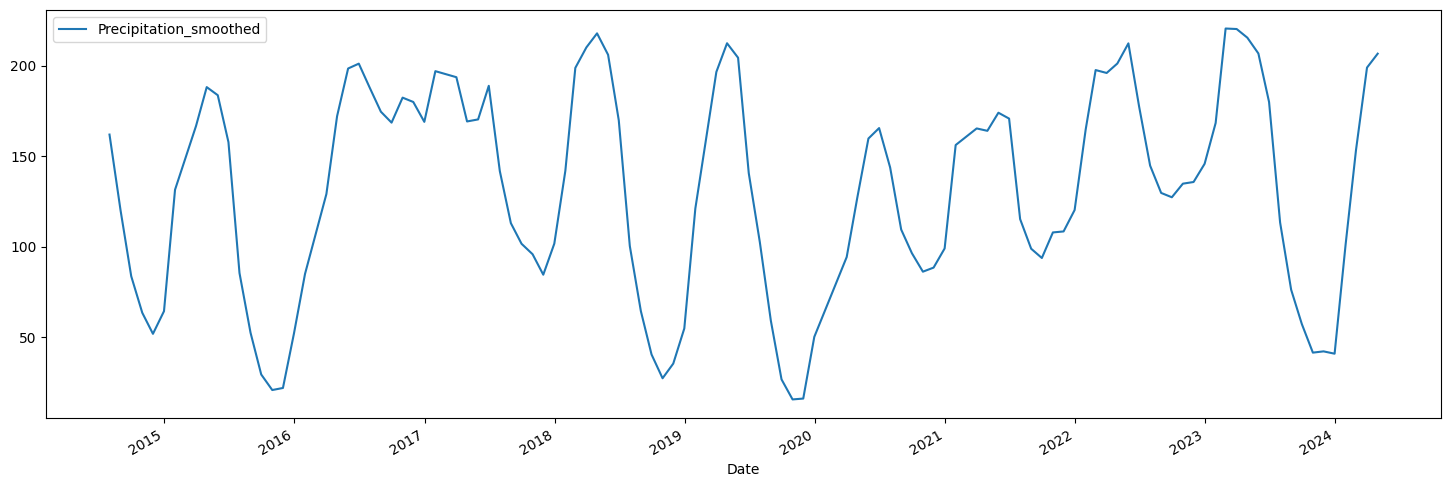

In [ ]:
jakbar_cleaned.plot(x='Date', y='Precipitation_smoothed', figsize=(18,6))

### Untuk bisa masuk ke model Prophet, fitur data perlu diubah menjadi ds dan y

#### column Precipitation masih ada, karena yang akan di predict adalah Precipitation_smoothed, atau data precipitation yang sudah di smoothing

In [ ]:
#rename data jadi ds dan y
jakbar_cleaned.rename(columns={'Date': 'ds', 'Precipitation_smoothed': 'y'}, inplace=True)
jakbar_cleaned

<ipython-input-44-10f146ce6aa4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,Precipitation,y
6,2014-07-31,113.428,161.9758
7,2014-08-31,37.958,120.1604
8,2014-09-30,15.395,83.7292
9,2014-10-31,19.598,63.5296
10,2014-11-30,73.141,51.9040
...,...,...,...
119,2023-12-31,49.395,40.9230
120,2024-01-31,337.704,101.3728
121,2024-02-29,267.375,153.2700
122,2024-03-31,248.121,198.9714


### Train Test split menggunakan Pareto Principle, bagi data jadi 80% train dan 20% test

In [ ]:
X = jakbar_cleaned[['ds']]
y = jakbar_cleaned['y']

#bagi train dan test jadi 80-20
train_size = int(len(jakbar_cleaned) * 0.80)
train = jakbar_cleaned.iloc[:train_size]
test = jakbar_cleaned.iloc[train_size:]

#model ke prophet dengan yearly_seasonality nyala biar keliatan seasonal tahunan
model = Prophet(yearly_seasonality=True)

#model di fit ke train
model.fit(train)

#future dibuat sebanyak jumlah test.
future = model.make_future_dataframe(periods = len(test), freq='M')

#future akan dicocokan dengan data test
forecast = model.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8l4oud8g/10mgiutz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8l4oud8g/3ury1lbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89554', 'data', 'file=/tmp/tmp8l4oud8g/10mgiutz.json', 'init=/tmp/tmp8l4oud8g/3ury1lbo.json', 'output', 'file=/tmp/tmp8l4oud8g/prophet_model6dbl1jtn/prophet_model-20240624031242.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:12:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:12:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### Tampilkan data train dan test

In [ ]:
print('Train data: ')
print(train)
print('---------------------------')
print('Test data: ')
print(test)

Train data: 
            ds  Precipitation         y
6   2014-07-31        113.428  161.9758
7   2014-08-31         37.958  120.1604
8   2014-09-30         15.395   83.7292
9   2014-10-31         19.598   63.5296
10  2014-11-30         73.141   51.9040
..         ...            ...       ...
96  2022-01-31        296.030  164.7090
97  2022-02-28        255.612  197.6126
98  2022-03-31        185.493  196.0096
99  2022-04-30        139.692  201.2362
100 2022-05-31        184.976  212.3606

[89 rows x 3 columns]
---------------------------
Test data: 
            ds  Precipitation         y
101 2022-06-30        121.991  177.5528
102 2022-07-31         91.985  144.8274
103 2022-08-31        110.028  129.7344
104 2022-09-30        127.732  127.3424
105 2022-10-31        222.536  134.8544
106 2022-11-30        126.583  135.7728
107 2022-12-31        142.200  145.8158
108 2023-01-31        222.822  168.3746
109 2023-02-28        388.678  220.5638
110 2023-03-31        221.133  220.2832
111 

In [ ]:
train.describe()

,ds,Precipitation,y
count,89,89.000000,89.000000
mean,2018-07-05 07:00:40.449438208,129.004921,128.428344
min,2014-07-31 00:00:00,7.811000,15.662200
25%,2016-07-31 00:00:00,61.651000,86.233600
50%,2018-06-30 00:00:00,123.262000,131.508200
75%,2020-06-30 00:00:00,183.031000,174.045400
max,2022-05-31 00:00:00,373.449000,217.888200
std,NaN,88.906094,57.874664


In [ ]:
#hasil forecast
#ds = date, trend= ?
#yhat_lower = interval bawah prediksi
#yhat_upper = interval atas prediksi
#yhat = hasil prediksi model
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-07-31,132.941871,82.709625,172.676782,132.941871,132.941871,-6.610080,-6.610080,-6.610080,-6.610080,-6.610080,-6.610080,0.0,0.0,0.0,126.331791
1,2014-08-31,132.953399,51.215215,146.467126,132.953399,132.953399,-33.389172,-33.389172,-33.389172,-33.389172,-33.389172,-33.389172,0.0,0.0,0.0,99.564226
2,2014-09-30,132.964555,36.329852,132.409608,132.964555,132.964555,-50.900948,-50.900948,-50.900948,-50.900948,-50.900948,-50.900948,0.0,0.0,0.0,82.063607
3,2014-10-31,132.976083,28.613696,123.393444,132.976083,132.976083,-56.765595,-56.765595,-56.765595,-56.765595,-56.765595,-56.765595,0.0,0.0,0.0,76.210488
4,2014-11-30,132.987239,25.070935,118.473520,132.987239,132.987239,-59.637452,-59.637452,-59.637452,-59.637452,-59.637452,-59.637452,0.0,0.0,0.0,73.349787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2023-12-31,134.220786,43.297552,138.611708,134.220778,134.220794,-44.802704,-44.802704,-44.802704,-44.802704,-44.802704,-44.802704,0.0,0.0,0.0,89.418082
108,2024-01-31,134.232310,86.060867,182.458263,134.232301,134.232319,0.375025,0.375025,0.375025,0.375025,0.375025,0.375025,0.0,0.0,0.0,134.607335
109,2024-02-29,134.243091,161.610101,260.314155,134.243081,134.243100,76.761535,76.761535,76.761535,76.761535,76.761535,76.761535,0.0,0.0,0.0,211.004626
110,2024-03-31,134.254615,104.336349,196.204582,134.254605,134.254625,15.052768,15.052768,15.052768,15.052768,15.052768,15.052768,0.0,0.0,0.0,149.307383


#### Perbandingan data asli dengan hasil forecast

In [ ]:
#perbandingan yhat(prediksi) dengan y(data asli yang sudah di smoothing)
print(forecast[['ds', 'yhat']].tail(24)) #13 = data test
print("-----------------------")
print(test)

            ds        yhat
88  2022-05-31  189.316472
89  2022-06-30  165.984065
90  2022-07-31  127.418141
91  2022-08-31  100.650572
92  2022-09-30   83.149949
93  2022-10-31   77.296826
94  2022-11-30   74.436122
95  2022-12-31   89.664291
96  2023-01-31  139.706131
97  2023-02-28  178.314919
98  2023-03-31  190.521609
99  2023-04-30  192.160685
100 2023-05-31  189.311236
101 2023-06-30  156.962993
102 2023-07-31  122.026987
103 2023-08-31  103.508487
104 2023-09-30   88.318116
105 2023-10-31   80.757472
106 2023-11-30   74.983026
107 2023-12-31   89.418082
108 2024-01-31  134.607335
109 2024-02-29  211.004626
110 2024-03-31  149.307383
111 2024-04-30  172.099274
-----------------------
            ds  Precipitation         y
101 2022-06-30        121.991  177.5528
102 2022-07-31         91.985  144.8274
103 2022-08-31        110.028  129.7344
104 2022-09-30        127.732  127.3424
105 2022-10-31        222.536  134.8544
106 2022-11-30        126.583  135.7728
107 2022-12-31       

In [ ]:
forecast[['ds', 'yhat']].tail(24)

,ds,yhat
88,2022-05-31,189.316472
89,2022-06-30,165.984065
90,2022-07-31,127.418141
91,2022-08-31,100.650572
92,2022-09-30,83.149949
93,2022-10-31,77.296826
94,2022-11-30,74.436122
95,2022-12-31,89.664291
96,2023-01-31,139.706131
97,2023-02-28,178.314919


## Plotting data actual dengan hasil forecast sepanjang data test

In [ ]:
#plotting data model(actual) dengan forecastnya
plot_plotly(model, forecast)

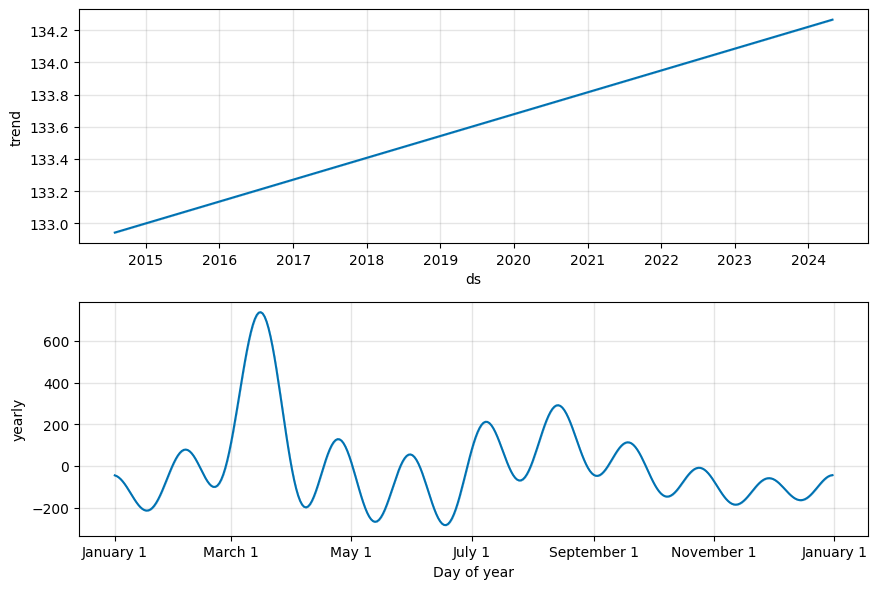

In [ ]:
#komponennya, trend dan plot yearly
plot2 = model.plot_components(forecast)

## Plot perbandingan data asli dengan hasil forecast Prophet

In [ ]:
forecast.iloc[-len(test):]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
89,2022-06-30,134.016696,117.412373,211.721862,134.016696,134.016696,31.967369,31.967369,31.967369,31.967369,31.967369,31.967369,0.0,0.0,0.0,165.984065
90,2022-07-31,134.028220,78.854819,172.337053,134.028220,134.028220,-6.610080,-6.610080,-6.610080,-6.610080,-6.610080,-6.610080,0.0,0.0,0.0,127.418141
91,2022-08-31,134.039745,55.175794,149.065346,134.039744,134.039745,-33.389172,-33.389172,-33.389172,-33.389172,-33.389172,-33.389172,0.0,0.0,0.0,100.650572
92,2022-09-30,134.050897,39.339345,129.759648,134.050896,134.050898,-50.900948,-50.900948,-50.900948,-50.900948,-50.900948,-50.900948,0.0,0.0,0.0,83.149949
93,2022-10-31,134.062421,29.635738,124.278306,134.062420,134.062422,-56.765595,-56.765595,-56.765595,-56.765595,-56.765595,-56.765595,0.0,0.0,0.0,77.296826
94,2022-11-30,134.073574,30.311949,119.755302,134.073572,134.073575,-59.637452,-59.637452,-59.637452,-59.637452,-59.637452,-59.637452,0.0,0.0,0.0,74.436122
95,2022-12-31,134.085098,44.023949,135.009096,134.085096,134.085099,-44.420806,-44.420806,-44.420806,-44.420806,-44.420806,-44.420806,0.0,0.0,0.0,89.664291
96,2023-01-31,134.096622,94.481127,186.280602,134.096620,134.096624,5.609509,5.609509,5.609509,5.609509,5.609509,5.609509,0.0,0.0,0.0,139.706131
97,2023-02-28,134.107031,131.484593,222.268034,134.107028,134.107033,44.207888,44.207888,44.207888,44.207888,44.207888,44.207888,0.0,0.0,0.0,178.314919
98,2023-03-31,134.118555,142.011841,236.256049,134.118552,134.118558,56.403054,56.403054,56.403054,56.403054,56.403054,56.403054,0.0,0.0,0.0,190.521609


## Perbandingan data asli, data asli yang di smoothing, dan hasil forecast model Prophet

In [ ]:
#dataframe perbandingan data actual, data smoothed, dan hasil forecasting
comparison_df = test.merge(forecast[['ds', 'yhat']], on='ds')
comparison_df.rename(columns={'Precipitation': 'actual_data', 'y': 'actual_smoothed', 'yhat': 'forecasted'}, inplace=True)
print(comparison_df)

           ds  actual_data  actual_smoothed  forecasted
0  2022-06-30      121.991         177.5528  165.984065
1  2022-07-31       91.985         144.8274  127.418141
2  2022-08-31      110.028         129.7344  100.650572
3  2022-09-30      127.732         127.3424   83.149949
4  2022-10-31      222.536         134.8544   77.296826
5  2022-11-30      126.583         135.7728   74.436122
6  2022-12-31      142.200         145.8158   89.664291
7  2023-01-31      222.822         168.3746  139.706131
8  2023-02-28      388.678         220.5638  178.314919
9  2023-03-31      221.133         220.2832  190.521609
10 2023-04-30      102.688         215.5042  192.160685
11 2023-05-31       98.571         206.7784  189.311236
12 2023-06-30       88.796         179.9732  156.962993
13 2023-07-31       55.835         113.4046  122.026987
14 2023-08-31       35.455          76.2690  103.508487
15 2023-09-30        7.889          57.3092   88.318116
16 2023-10-31       19.614          41.5178   80

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comparison_df['ds'], y=comparison_df['actual_smoothed'], mode='lines', name='Actual'))


fig.add_trace(go.Scatter(x=comparison_df['ds'], y=comparison_df['forecasted'], mode='lines', name='Forecast'))

# Update layout with title and axis labels
fig.update_layout(title="Perbandingan data curah Hujan Jakarta Barat dengan hasil forecast curah hujan Jakarta Barat (Prophet)", xaxis_title="Tanggal", yaxis_title="Curah Hujan")
fig.show()

## Evaluasi Model menggunakan Root Mean Square Error

In [ ]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

#ambil prediksi sebanyak test. ambil fitur ds dan yhat
forecast_test = forecast.loc[forecast['ds'].isin(test['ds']), 'yhat']

predictions = forecast_test.values
actuals = test['y'].values

#root mean square error = mean dari error/jarak perbedaan data actual dengan data predicted
rmse_value = rmse(actuals, predictions)
print("Root Mean Squared Error between actual and predicted values for Prophet: ", rmse_value)

# mean absolute percentage error
mape_value = mean_absolute_percentage_error(actuals, predictions)
print("Mean Absolute Percentage Error between actual and predicted values for Prophet: ", mape_value)

Root Mean Squared Error between actual and predicted values for Prophet:  37.980865372582684
Mean Absolute Percentage Error between actual and predicted values for Prophet:  0.3408700741497413


# Terima kasih atas perhatiannya

# Sebelum itu, lakukan forecast untuk curah hujan untuk 12 bulan kedepan, terhitung dari Maret 2024

## Prediksi 12 bulan kedepan

In [ ]:
#coba modelling dengan data asli, bukan data train
#ada sekitar 94 data asli yang akan di forecast
model_jakbar_12bulan = Prophet(yearly_seasonality = True)

# Model fit ke data asli
model_jakbar_12bulan.fit(jakbar_cleaned)

#di forecast untuk 12 bulan kedepan
future_12bulan = model_jakbar_12bulan.make_future_dataframe(periods = 12, freq='M')
forecast_12bulan = model_jakbar_12bulan.predict(future_12bulan)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8l4oud8g/m39twtl5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8l4oud8g/mr08qsip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52416', 'data', 'file=/tmp/tmp8l4oud8g/m39twtl5.json', 'init=/tmp/tmp8l4oud8g/mr08qsip.json', 'output', 'file=/tmp/tmp8l4oud8g/prophet_model1iae3jwo/prophet_model-20240624031244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:12:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:12:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Plotting hasil prediksi 12 bulan kedepan (dari Maret 2024)

In [ ]:
print(forecast_12bulan[['ds', 'yhat']].tail(14))

            ds        yhat
110 2024-03-31  183.562955
111 2024-04-30  193.270329
112 2024-05-31  197.005082
113 2024-06-30  178.728344
114 2024-07-31  136.791111
115 2024-08-31  106.156436
116 2024-09-30   89.134664
117 2024-10-31   84.408728
118 2024-11-30   84.566551
119 2024-12-31   98.009044
120 2025-01-31  148.671035
121 2025-02-28  189.275484
122 2025-03-31  184.878537
123 2025-04-30  194.907992


In [ ]:
#hasil plotnya
plot_plotly(model_jakbar_12bulan, forecast_12bulan)

In [ ]:
#hasil forecast data asli
forecast_12bulan[['ds', 'yhat']].tail(13)

,ds,yhat
111,2024-04-30,193.270329
112,2024-05-31,197.005082
113,2024-06-30,178.728344
114,2024-07-31,136.791111
115,2024-08-31,106.156436
116,2024-09-30,89.134664
117,2024-10-31,84.408728
118,2024-11-30,84.566551
119,2024-12-31,98.009044
120,2025-01-31,148.671035


In [ ]:
fig.add_trace(go.Scatter(x=forecast_12bulan['ds'], y=forecast_12bulan['yhat'], mode='lines', name='Forecast 12 Bulan'))

# Update layout with title and axis labels
fig.update_layout(title="Prediksi curah hujan akan terjadi menggunakan Prophet", xaxis_title="Tanggal", yaxis_title="Curah Hujan")
fig.show()

In [ ]:
#perbandingan data asli, dengan hasil forecast
df_perbandingan_data_asli = jakbar_cleaned.merge(forecast_12bulan[['ds', 'yhat']], on='ds')
df_perbandingan_data_asli.rename(columns={'Precipitation': 'actual_data', 'y': 'actual_smoothed', 'yhat': 'forecasted'}, inplace=True)
print(df_perbandingan_data_asli)

            ds  actual_data  actual_smoothed  forecasted
0   2014-07-31      113.428         161.9758  122.503071
1   2014-08-31       37.958         120.1604   92.581913
2   2014-09-30       15.395          83.7292   75.343615
3   2014-10-31       19.598          63.5296   70.461614
4   2014-11-30       73.141          51.9040   69.614078
..         ...          ...              ...         ...
107 2023-12-31       49.395          40.9230   95.874028
108 2024-01-31      337.704         101.3728  146.106663
109 2024-02-29      267.375         153.2700  188.094496
110 2024-03-31      248.121         198.9714  183.562955
111 2024-04-30      130.738         206.6666  193.270329

[112 rows x 4 columns]


In [ ]:
forecast_12bulan.loc[forecast_12bulan['ds'].isin(jakbar_cleaned['ds']), 'yhat'].shape

(112,)

In [ ]:
#evaluasi lagi menggunakan rmse
forecast_test_1 = forecast_12bulan.loc[forecast_12bulan['ds'].isin(jakbar_cleaned['ds']), 'yhat']
predictions_1 = forecast_test_1.values
actuals_1 = jakbar_cleaned['y'].values

rmse_value = rmse(actuals_1, predictions_1)
print("Root Mean Squared Error between actual and  predicted values: ", rmse_value)


# mean absolute percentage error
mape_value = mean_absolute_percentage_error(actuals_1, predictions_1)
print("Mean Absolute Percentage Error between actual and predicted values for Prophet: ", mape_value)

Root Mean Squared Error between actual and  predicted values:  36.58859089834143
Mean Absolute Percentage Error between actual and predicted values for Prophet:  0.40509524533683855
